In [1]:
import holidays
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

In [2]:
df = pd.read_csv('paychecks.csv')
df.sort_values(by=['EmployeeID', 'EndDate'], inplace=True)
df.head(15)

,EmployeeID,StartDate,EndDate,Amount,PaymentType,HourlyRate,MonthlySalary,HoursWorked
23959,1,2020-01-01,2020-01-08,10574.57,monthly,NaN,10574.57,NaN
37947,1,2020-01-08,2020-01-15,10574.57,monthly,NaN,10574.57,NaN
37819,1,2020-01-15,2020-01-22,10574.57,monthly,NaN,10574.57,NaN
24376,1,2020-01-22,2020-01-29,10574.57,monthly,NaN,10574.57,NaN
27077,1,2020-01-29,2020-02-05,10574.57,monthly,NaN,10574.57,NaN
30280,1,2020-02-05,2020-02-12,10574.57,monthly,NaN,10574.57,NaN
35370,1,2020-02-12,2020-02-19,10574.57,monthly,NaN,10574.57,NaN
37232,1,2020-02-19,2020-02-26,10574.57,monthly,NaN,10574.57,NaN
20469,1,2020-02-26,2020-03-04,10574.57,monthly,NaN,10574.57,NaN
4125,1,2020-03-04,2020-03-11,10574.57,monthly,NaN,10574.57,NaN


## Feature Engineering

In [3]:
us_holidays = holidays.US()

def count_holidays(start_date, end_date):
    """Count US holidays between start_date and end_date"""
    holiday_count = 0
    current_date = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    while current_date <= end:
        if current_date in us_holidays:
            holiday_count += 1
        current_date += pd.Timedelta(days=1)
    
    return holiday_count

def calculate_rolling_stats(df, column, window_sizes=[3, 6, 12]):
    """Calculate rolling mean and standard deviation for a column"""
    result_df = df.copy()
    
    result_df = result_df.sort_values(['EmployeeID', 'EndDate'])
    
    for employee in result_df['EmployeeID'].unique():
        employee_mask = result_df['EmployeeID'] == employee
        
        for window in window_sizes:
            result_df.loc[employee_mask, f'{column}_rolling_mean_{window}'] = (
                result_df.loc[employee_mask, column].rolling(window=window, min_periods=1).mean()
            )
            
            result_df.loc[employee_mask, f'{column}_rolling_std_{window}'] = (
                result_df.loc[employee_mask, column].rolling(window=window, min_periods=1).std()
            )
    
    return result_df

def calculate_payment_features(df):
    """Comprehensive feature engineering function integrating all approaches"""

    result_df = df.copy()
    
    result_df['StartDate'] = pd.to_datetime(result_df['StartDate'])
    result_df['EndDate'] = pd.to_datetime(result_df['EndDate'])
    
    # Calculate holiday counts
    result_df['holiday_count'] = result_df.apply(
        lambda row: count_holidays(row['StartDate'], row['EndDate']), axis=1
    )
    
    # Apply rolling statistics to key columns
    result_df = calculate_rolling_stats(result_df, 'Amount', window_sizes=[3, 6, 12])
    result_df = calculate_rolling_stats(result_df, 'HourlyRate', window_sizes=[3, 6, 12])
    result_df = calculate_rolling_stats(result_df, 'HoursWorked', window_sizes=[3, 6, 12])
    
    # Payment frequency and regularity
    result_df['days_between'] = result_df.groupby('EmployeeID')['StartDate'].diff().dt.days
    result_df['payment_frequency'] = result_df.groupby('EmployeeID')['days_between'].transform('median')
    result_df['payment_regularity'] = result_df.groupby('EmployeeID')['days_between'].transform('std').fillna(0)
    
    # Employee tenure and payment sequence
    result_df['first_payment_date'] = result_df.groupby('EmployeeID')['StartDate'].transform('min')
    result_df['days_since_first_payment'] = (result_df['StartDate'] - result_df['first_payment_date']).dt.days
    result_df['payment_sequence'] = result_df.groupby('EmployeeID').cumcount() + 1
    
    # Time-based features
    result_df['date_delta'] = result_df['EndDate'] - result_df['StartDate']
    result_df['start_date_day'] = result_df['StartDate'].dt.day
    result_df['start_date_month'] = result_df['StartDate'].dt.month
    result_df['start_date_weekday'] = result_df['StartDate'].dt.weekday
    result_df['end_date_day'] = result_df['EndDate'].dt.day
    result_df['end_date_month'] = result_df['EndDate'].dt.month
    result_df['end_date_weekday'] = result_df['EndDate'].dt.weekday
    result_df['quarter'] = result_df['StartDate'].dt.quarter
    result_df['year'] = result_df['StartDate'].dt.year
    result_df['day_of_year'] = result_df['StartDate'].dt.dayofyear
    result_df['week_of_year'] = result_df['StartDate'].dt.isocalendar().week
    
    # Payment type indicators
    result_df['is_hourly'] = (result_df['PaymentType'] == 'hourly').astype(int)
    
    # Payment stability metrics
    result_df['payment_coefficient_variation'] = result_df.groupby('EmployeeID')['Amount'].transform(
        lambda x: x.rolling(window=6, min_periods=1).std() / (x.rolling(window=6, min_periods=1).mean() + 0.001)
    ).fillna(0)
    
    # For hourly employees
    hourly_mask = result_df['PaymentType'] == 'hourly'
    
    # Average pay per hour
    result_df.loc[hourly_mask, 'pay_per_hour'] = np.where(
        result_df.loc[hourly_mask, 'HoursWorked'] > 0,
        result_df.loc[hourly_mask, 'Amount'] / result_df.loc[hourly_mask, 'HoursWorked'],
        0
    )
    
    # Hours volatility 
    result_df.loc[hourly_mask, 'hours_volatility'] = result_df[hourly_mask].groupby('EmployeeID')['HoursWorked'].transform(
        lambda x: x.rolling(window=6, min_periods=1).std() / (x.rolling(window=6, min_periods=1).mean() + 0.001)
    ).fillna(0)
    
    # Lag features (previous n payments)
    for lag in [1, 2, 3]:
        result_df[f'amount_lag_{lag}'] = result_df.groupby('EmployeeID')['Amount'].shift(lag)
        
        # For hourly employees
        result_df.loc[hourly_mask, f'hours_lag_{lag}'] = result_df.loc[hourly_mask].groupby('EmployeeID')['HoursWorked'].shift(lag)
    
    # Recent trend calculation
    result_df['amount_pct_change'] = result_df.groupby('EmployeeID')['Amount'].pct_change()
    result_df['amount_diff'] = result_df.groupby('EmployeeID')['Amount'].diff()
    
    
    # Moving average convergence/divergence
    result_df['amount_3ma_6ma_diff'] = result_df['Amount_rolling_mean_3'] - result_df['Amount_rolling_mean_6']
    
    # Fill NaN values
    result_df = result_df.fillna(0)
    
    return result_df

def calculate_employee_stats(df):
    """Calculate employee stats using only data available at that point in time"""
    
    # Sort data by employee and date
    df = df.sort_values(['EmployeeID', 'EndDate'])
    
    # Create expanding window statistics
    df['Amount_rolling_mean'] = df.groupby('EmployeeID')['Amount'].transform(
        lambda x: x.expanding().mean()
    )
    
    df['Amount_rolling_std'] = df.groupby('EmployeeID')['Amount'].transform(
        lambda x: x.expanding().std()
    ).fillna(0)
    
    df['Amount_rolling_min'] = df.groupby('EmployeeID')['Amount'].transform(
        lambda x: x.expanding().min()
    )
    
    df['Amount_rolling_max'] = df.groupby('EmployeeID')['Amount'].transform(
        lambda x: x.expanding().max()
    )
    
    # Similar for HoursWorked
    hourly_mask = df['PaymentType'] == 'hourly'
    
    df.loc[hourly_mask, 'HoursWorked_rolling_mean'] = df.loc[hourly_mask].groupby('EmployeeID')['HoursWorked'].transform(
        lambda x: x.expanding().mean()
    )
    
    df.loc[hourly_mask, 'HoursWorked_rolling_std'] = df.loc[hourly_mask].groupby('EmployeeID')['HoursWorked'].transform(
        lambda x: x.expanding().std()
    ).fillna(0)
    
    df.loc[hourly_mask, 'HoursWorked_rolling_min'] = df.loc[hourly_mask].groupby('EmployeeID')['HoursWorked'].transform(
        lambda x: x.expanding().min()
    )
    
    df.loc[hourly_mask, 'HoursWorked_rolling_max'] = df.loc[hourly_mask].groupby('EmployeeID')['HoursWorked'].transform(
        lambda x: x.expanding().max()
    )
    
    # Payment consistency metric (using only prior data)
    df['amount_to_avg_ratio'] = df['Amount'] / (df['Amount_rolling_mean'] + 0.001)
    
    # Z-score for amount (using only prior data)
    df['amount_zscore'] = (df['Amount'] - df['Amount_rolling_mean']) / (df['Amount_rolling_std'] + 0.001)
    df['is_amount_outlier'] = (df['amount_zscore'].abs() > 2).astype(int)
    
    # Payment stability over time - coefficient of variation based on expanding window
    df['payment_stability'] = df['Amount_rolling_std'] / (df['Amount_rolling_mean'] + 0.001)
    
    # Fill any NaNs
    df = df.fillna(0)
    
    return df

def prepare_full_feature_set(df):
    """Full feature preparation pipeline"""
    
    # Step 1: Calculate payment features (includes rolling stats and holiday counts)
    df_with_payment_features = calculate_payment_features(df)
    
    # Step 2: Add time-aware employee statistics
    df_with_all_features = calculate_employee_stats(df_with_payment_features)
    
    # Step 3: Create target variable
    df_with_all_features['next_amount'] = df_with_all_features.groupby('EmployeeID')['Amount'].shift(-1)
    
    return df_with_all_features

In [4]:
df = prepare_full_feature_set(df)

In [5]:
df.describe()

,EmployeeID,StartDate,EndDate,Amount,HourlyRate,MonthlySalary,HoursWorked,holiday_count,Amount_rolling_mean_3,Amount_rolling_std_3,...,Amount_rolling_max,HoursWorked_rolling_mean,HoursWorked_rolling_std,HoursWorked_rolling_min,HoursWorked_rolling_max,amount_to_avg_ratio,amount_zscore,is_amount_outlier,payment_stability,next_amount
count,40524.000000,40524,40524,40524.000000,40524.000000,40524.000000,40524.00000,40524.000000,40524.000000,40524.000000,...,40524.000000,40524.000000,40524.000000,40524.00000,40524.000000,40524.000000,40524.000000,40524.000000,40524.000000,40024.000000
mean,247.857517,2021-04-25 06:03:16.150429184,2021-05-05 20:16:20.752146944,5213.042493,24.607111,3242.496147,49.62086,0.385179,5211.087000,295.123376,...,6205.138362,49.588262,9.155543,23.23061,75.798940,1.011851,0.137070,0.042493,0.120566,5210.951839
min,1.000000,2020-01-01 00:00:00,2020-01-08 00:00:00,54.180000,0.000000,0.000000,0.00000,0.000000,252.663333,0.000000,...,354.110000,0.000000,0.000000,0.00000,0.000000,0.099762,-5.652913,0.000000,0.000000,54.180000
25%,122.000000,2020-07-29 00:00:00,2020-08-12 00:00:00,2266.972500,0.000000,0.000000,0.00000,0.000000,2291.030833,0.000000,...,3463.070000,0.000000,0.000000,0.00000,0.000000,0.978922,-0.118080,0.000000,0.000000,2261.737500
50%,250.000000,2021-03-24 00:00:00,2021-04-07 00:00:00,4661.220000,27.430000,0.000000,52.75000,0.000000,4641.661667,135.255328,...,6533.100000,55.255917,9.646594,12.50000,84.750000,1.000000,0.000000,0.000000,0.143172,4653.435000
75%,376.000000,2021-12-29 00:00:00,2022-01-12 00:00:00,8185.560000,42.610000,8080.570000,90.75000,1.000000,8150.240000,394.148167,...,8643.340000,103.635236,13.741817,38.25000,120.750000,1.058125,0.492402,0.000000,0.200806,8185.560000
max,500.000000,2022-12-28 00:00:00,2023-01-11 00:00:00,16500.200000,102.430000,12038.500000,212.50000,2.000000,14559.000000,5134.020000,...,16500.200000,204.750000,76.367532,204.75000,212.500000,2.106470,9.055961,1.000000,1.087859,16500.200000
std,144.642150,NaN,NaN,3175.230626,22.466143,4283.483030,45.82690,0.613874,3141.300775,462.964169,...,2975.862997,44.089561,9.033629,28.65482,68.521218,0.155750,0.884512,0.201714,0.099060,3177.497733


## EDA

In [6]:
def format_currency(x, pos):
    """Format y-axis ticks as currency"""
    return f"${x:,.0f}"

def plot_payment_time_series(df, num_employees=5, figsize=(12, 8)):
    """Plot payment amount time series for a sample of employees"""
    plt.figure(figsize=figsize)
    
    # Select a sample of employees
    employees = np.random.choice(df['EmployeeID'].unique(), size=min(num_employees, len(df['EmployeeID'].unique())), replace=False)
    
    for employee_id in employees:
        employee_data = df[df['EmployeeID'] == employee_id].sort_values('EndDate')
        plt.plot(employee_data['EndDate'], employee_data['Amount'], marker='o', markersize=4, label=f'Employee {employee_id}')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_currency))
    
    plt.title('Payment Amount Over Time (Sample Employees)', fontsize=14)
    plt.xlabel('Payment Date', fontsize=12)
    plt.ylabel('Payment Amount', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt

def plot_payment_distribution(df, figsize=(12, 6)):
    """Plot distribution of payment amounts by payment type"""
    plt.figure(figsize=figsize)
    
    # Create two subplots
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    
    # Plot histograms for each payment type
    monthly_data = df[df['PaymentType'] == 'monthly']['Amount']
    hourly_data = df[df['PaymentType'] == 'hourly']['Amount']
    
    # Histogram for monthly employees
    sns.histplot(monthly_data, bins=30, kde=True, color='steelblue', ax=ax1)
    ax1.set_title('Monthly Payment Distribution', fontsize=12)
    ax1.set_xlabel('Payment Amount', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    ax1.xaxis.set_major_formatter(FuncFormatter(format_currency))
    
    # Histogram for hourly employees
    sns.histplot(hourly_data, bins=30, kde=True, color='darkorange', ax=ax2)
    ax2.set_title('Hourly Payment Distribution', fontsize=12)
    ax2.set_xlabel('Payment Amount', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.xaxis.set_major_formatter(FuncFormatter(format_currency))
    
    plt.tight_layout()
    
    return plt

def plot_payment_by_day_of_week(df, figsize=(12, 6)):
    """Plot payment patterns by day of week"""
    plt.figure(figsize=figsize)
    
    # Convert weekday to categorical
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df_copy = df.copy()
    df_copy['weekday'] = df_copy['EndDate'].dt.dayofweek
    df_copy['weekday_name'] = df_copy['weekday'].apply(lambda x: days[x])
    
    # Count payments by day of week and payment type
    payment_counts = df_copy.groupby(['weekday_name', 'PaymentType']).size().unstack().fillna(0)
    
    # Sort by weekday order
    payment_counts = payment_counts.reindex(days)
    
    # Create plot
    ax = payment_counts.plot(kind='bar', stacked=True, color=['steelblue', 'darkorange'])
    
    # Labels
    plt.title('Payment Frequency by Day of Week', fontsize=14)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Number of Payments', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Payment Type')
    plt.tight_layout()
    
    return plt

def plot_hours_vs_amount(df, figsize=(10, 6)):
    """Plot hours worked vs payment amount for hourly employees"""
    fig, ax = plt.subplots(figsize=figsize)
    
    # Filter hourly employees with hours worked
    hourly_data = df[(df['PaymentType'] == 'hourly') & (df['HoursWorked'] > 0)]
    
    # Create scatter plot
    ax.scatter(hourly_data['HoursWorked'], hourly_data['Amount'], 
                alpha=0.5, c='darkblue', edgecolor='none', s=30)
    
    # Add trend line
    z = np.polyfit(hourly_data['HoursWorked'], hourly_data['Amount'], 1)
    p = np.poly1d(z)
    ax.plot(hourly_data['HoursWorked'], p(hourly_data['HoursWorked']), 
             linestyle='--', color='red', linewidth=2)
    
    # Add annotation showing the formula
    slope, intercept = z
    ax.annotate(f'Amount = ${slope:.2f} × Hours + ${intercept:.2f}', 
                 xy=(0.05, 0.95), xycoords='axes fraction', 
                 fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
    
    # Labels
    ax.set_title('Payment Amount vs. Hours Worked (Hourly Employees)', fontsize=14)
    ax.set_xlabel('Hours Worked', fontsize=12)
    ax.set_ylabel('Payment Amount', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Set formatter on the correct axis object
    ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
    
    plt.tight_layout()
    
    return plt

def plot_heatmap_monthly_patterns(df, figsize=(14, 8)):
    """Plot heatmap of payment patterns by month and year"""
    plt.figure(figsize=figsize)
    
    # Extract year and month
    df_copy = df.copy()
    df_copy['year'] = df_copy['EndDate'].dt.year
    df_copy['month'] = df_copy['EndDate'].dt.month
    
    # Calculate median payment by month and year
    monthly_median = df_copy.groupby(['year', 'month'])['Amount'].median().reset_index()
    
    # Pivot the data to create a matrix year×month
    heatmap_data = monthly_median.pivot(index='year', columns='month', values='Amount')
    
    # Create heatmap
    ax = plt.subplot(1, 1, 1)
    im = ax.imshow(heatmap_data, cmap='YlGnBu')
    
    # Labels
    ax.set_title('Median Payment Amount by Month and Year', fontsize=14)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Year', fontsize=12)
    
    # Set x ticks (months)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(np.arange(len(month_names)))
    ax.set_xticklabels(month_names)
    
    # Set y ticks (years)
    ax.set_yticks(np.arange(len(heatmap_data.index)))
    ax.set_yticklabels(heatmap_data.index)
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('Median Payment Amount', rotation=-90, va="bottom")
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
    
    # Loop through cells to add text
    for i in range(len(heatmap_data.index)):
        for j in range(len(month_names)):
            if not np.isnan(heatmap_data.iloc[i, j]):
                text = ax.text(j, i, f"${heatmap_data.iloc[i, j]:,.0f}", 
                               ha="center", va="center", color="black" if heatmap_data.iloc[i, j] < heatmap_data.max().max()/1.5 else "white")
    
    plt.tight_layout()
    
    return plt

def plot_payment_stability(df, num_employees=10, figsize=(12, 6)):
    """Plot payment stability (coefficient of variation) by employee"""
    plt.figure(figsize=figsize)
    
    # Calculate coefficient of variation for each employee
    employee_stats = df.groupby('EmployeeID').agg({
        'Amount': ['mean', 'std'],
        'PaymentType': lambda x: x.iloc[0]  # Get payment type
    })
    
    # Flatten multi-index
    employee_stats.columns = ['_'.join(col).strip() for col in employee_stats.columns.values]
    
    # Calculate CV (coefficient of variation)
    employee_stats['cv'] = employee_stats['Amount_std'] / employee_stats['Amount_mean']
    
    # Sort by CV
    employee_stats = employee_stats.sort_values('cv')
    
    # Select sample employees
    if len(employee_stats) > num_employees:
        # Get a mix of stable and variable employees
        stable_half = employee_stats.head(num_employees // 2)
        variable_half = employee_stats.tail(num_employees // 2)
        employee_stats = pd.concat([stable_half, variable_half])
    
    # Plot
    colors = ['steelblue' if payment_type == 'monthly' else 'darkorange' 
              for payment_type in employee_stats['PaymentType_<lambda>']]
    
    ax = plt.bar(range(len(employee_stats)), employee_stats['cv'], color=colors)
    
    # Add labels
    plt.title('Payment Stability by Employee', fontsize=14)
    plt.xlabel('Employee ID', fontsize=12)
    plt.ylabel('Coefficient of Variation (Lower = More Stable)', fontsize=12)
    plt.xticks(range(len(employee_stats)), employee_stats.index, rotation=90)
    plt.grid(axis='y', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', label='Monthly'),
        Patch(facecolor='darkorange', label='Hourly')
    ]
    plt.legend(handles=legend_elements, title='Payment Type')
    
    plt.tight_layout()
    
    return plt

def plot_correlation_matrix(df, figsize=(12, 10)):
    """Plot correlation matrix of key features"""
    # Select relevant numeric columns
    num_cols = [
        'Amount', 'HourlyRate', 'HoursWorked', 'holiday_count',
        'start_date_day', 'start_date_month', 'start_date_weekday',
        'end_date_day', 'end_date_month', 'end_date_weekday'
    ]
    
    # Add rolling stats if available
    for col in df.columns:
        if 'rolling' in col and col.endswith(('3', '6', '12')):
            num_cols.append(col)
    
    # Filter to columns that exist in the dataframe
    num_cols = [col for col in num_cols if col in df.columns]
    
    # Create correlation matrix
    corr = df[num_cols].corr()
    
    # Plot
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Create heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.tight_layout()
    
    return plt

def plot_payment_distribution_by_employee(df, num_employees=9, figsize=(15, 12)):
    """Plot payment distribution boxplots for a sample of employees"""
    plt.figure(figsize=figsize)
    
    # Select a sample of employees
    employees = np.random.choice(df['EmployeeID'].unique(), 
                                 size=min(num_employees, len(df['EmployeeID'].unique())), 
                                 replace=False)
    
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()
    
    for i, employee_id in enumerate(employees):
        if i >= len(axes):
            break
            
        employee_data = df[df['EmployeeID'] == employee_id]
        payment_type = employee_data['PaymentType'].iloc[0]
        
        # Create boxplot
        sns.boxplot(y=employee_data['Amount'], ax=axes[i], 
                   color='steelblue' if payment_type == 'monthly' else 'darkorange')
        
        # Add jittered points
        sns.stripplot(y=employee_data['Amount'], ax=axes[i], color='black', alpha=0.5, jitter=0.3, size=4)
        
        # Add title and format y-axis
        axes[i].set_title(f'Employee {employee_id} ({payment_type.capitalize()})', fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Payment Amount', fontsize=10)
        axes[i].yaxis.set_major_formatter(FuncFormatter(format_currency))
        
    # Remove empty subplots if any
    for i in range(len(employees), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    
    return plt

def plot_seasonal_patterns(df, figsize=(15, 8)):
    """Plot seasonal patterns in payments by month"""
    plt.figure(figsize=figsize)
    
    # Extract year and month
    df_copy = df.copy()
    df_copy['year'] = df_copy['EndDate'].dt.year
    df_copy['month'] = df_copy['EndDate'].dt.month
    
    # Aggregate by month and payment type
    monthly_data = df_copy.groupby(['month', 'PaymentType']).agg({
        'Amount': ['mean', 'median', 'count']
    }).reset_index()
    
    # Flatten multi-index columns
    monthly_data.columns = ['_'.join(col).strip() for col in monthly_data.columns.values]
    monthly_data.rename(columns={'month_': 'month', 'PaymentType_': 'PaymentType'}, inplace=True)
    
    # Create figure with 2 subplots (mean and count)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Plot average amount by month and payment type
    for payment_type, color in zip(['monthly', 'hourly'], ['steelblue', 'darkorange']):
        data = monthly_data[monthly_data['PaymentType'] == payment_type]
        ax1.plot(data['month'], data['Amount_mean'], marker='o', linewidth=2, label=f'{payment_type.capitalize()}', color=color)
    
    ax1.set_title('Average Payment Amount by Month', fontsize=14)
    ax1.set_xlabel('')
    ax1.set_ylabel('Average Amount', fontsize=12)
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax1.yaxis.set_major_formatter(FuncFormatter(format_currency))
    ax1.grid(True, alpha=0.3)
    ax1.legend(title='Payment Type')
    
    # Plot payment count by month and payment type
    for payment_type, color in zip(['monthly', 'hourly'], ['steelblue', 'darkorange']):
        data = monthly_data[monthly_data['PaymentType'] == payment_type]
        ax2.plot(data['month'], data['Amount_count'], marker='o', linewidth=2, label=f'{payment_type.capitalize()}', color=color)
    
    ax2.set_title('Payment Frequency by Month', fontsize=14)
    ax2.set_xlabel('Month', fontsize=12)
    ax2.set_ylabel('Number of Payments', fontsize=12)
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax2.grid(True, alpha=0.3)
    ax2.legend(title='Payment Type')
    
    plt.tight_layout()
    
    return plt

def plot_holiday_impact(df, figsize=(12, 6)):
    """Plot impact of holidays on payment amount"""
    plt.figure(figsize=figsize)
    
    # Ensure holiday_count column exists
    if 'holiday_count' not in df.columns:
        df['holiday_count'] = df.apply(lambda row: count_holidays(row['StartDate'], row['EndDate']), axis=1)
    
    # Group by holiday count and payment type
    holiday_impact = df.groupby(['holiday_count', 'PaymentType']).agg({
        'Amount': ['mean', 'median', 'count']
    }).reset_index()
    
    # Flatten multi-index columns
    holiday_impact.columns = ['_'.join(col).strip() for col in holiday_impact.columns.values]
    holiday_impact.rename(columns={'holiday_count_': 'holiday_count', 'PaymentType_': 'PaymentType'}, inplace=True)
    
    # Filter to reasonable holiday counts (0-5)
    holiday_impact = holiday_impact[holiday_impact['holiday_count'] <= 5]
    
    # Create separate subplots for hourly and monthly
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot for hourly employees
    hourly_data = holiday_impact[holiday_impact['PaymentType'] == 'hourly']
    ax1.bar(hourly_data['holiday_count'], hourly_data['Amount_mean'], color='darkorange')
    ax1.set_title('Hourly Employees: Effect of Holidays', fontsize=12)
    ax1.set_xlabel('Number of Holidays in Period', fontsize=10)
    ax1.set_ylabel('Average Payment Amount', fontsize=10)
    ax1.yaxis.set_major_formatter(FuncFormatter(format_currency))
    ax1.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, count in enumerate(hourly_data['Amount_count']):
        if not np.isnan(hourly_data['Amount_mean'].iloc[i]):
            ax1.text(hourly_data['holiday_count'].iloc[i], hourly_data['Amount_mean'].iloc[i] + 100, 
                    f"n={count}", ha='center', fontsize=9)
    
    # Plot for monthly employees
    monthly_data = holiday_impact[holiday_impact['PaymentType'] == 'monthly']
    ax2.bar(monthly_data['holiday_count'], monthly_data['Amount_mean'], color='steelblue')
    ax2.set_title('Monthly Employees: Effect of Holidays', fontsize=12)
    ax2.set_xlabel('Number of Holidays in Period', fontsize=10)
    ax2.set_ylabel('Average Payment Amount', fontsize=10)
    ax2.yaxis.set_major_formatter(FuncFormatter(format_currency))
    ax2.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, count in enumerate(monthly_data['Amount_count']):
        if not np.isnan(monthly_data['Amount_mean'].iloc[i]):
            ax2.text(monthly_data['holiday_count'].iloc[i], monthly_data['Amount_mean'].iloc[i] + 100, 
                    f"n={count}", ha='center', fontsize=9)
    
    plt.tight_layout()
    
    return plt

def plot_all_eda_visualizations(df, output_dir=None):
    """Generate and save all EDA visualizations individually to avoid errors"""
    # Make sure output directory exists if specified
    if output_dir:
        import os
        os.makedirs(output_dir, exist_ok=True)
    
    # Process data if needed
    df_copy = df.copy()
    df_copy['StartDate'] = pd.to_datetime(df_copy['StartDate'])
    df_copy['EndDate'] = pd.to_datetime(df_copy['EndDate'])
    
    # Ensure we have holiday_count
    if 'holiday_count' not in df_copy.columns:
        # Define count_holidays function if needed
        import holidays
        us_holidays = holidays.US()
        
        def count_holidays(start_date, end_date):
            holiday_count = 0
            current_date = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            
            while current_date <= end:
                if current_date in us_holidays:
                    holiday_count += 1
                current_date += pd.Timedelta(days=1)
            
            return holiday_count
        
        df_copy['holiday_count'] = df_copy.apply(lambda row: count_holidays(row['StartDate'], row['EndDate']), axis=1)
    
    # Generate visualizations one by one to isolate any errors
    visualizations = []
    
    try:
        print("Generating payment time series plot...")
        plot = plot_payment_time_series(df_copy)
        visualizations.append(('payment_time_series', plot))
        if output_dir:
            plot.savefig(f"{output_dir}/payment_time_series.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating payment time series plot: {e}")
    
    try:
        print("Generating payment distribution plot...")
        plot = plot_payment_distribution(df_copy)
        visualizations.append(('payment_distribution', plot))
        if output_dir:
            plot.savefig(f"{output_dir}/payment_distribution.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating payment distribution plot: {e}")
    
    try:
        print("Generating payment by day of week plot...")
        plot = plot_payment_by_day_of_week(df_copy)
        visualizations.append(('payment_by_day_of_week', plot))
        if output_dir:
            plot.savefig(f"{output_dir}/payment_by_day_of_week.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating payment by day of week plot: {e}")
    
    try:
        print("Generating hours vs amount plot...")
        plot = plot_hours_vs_amount(df_copy)
        visualizations.append(('hours_vs_amount', plot))
        if output_dir:
            plot.savefig(f"{output_dir}/hours_vs_amount.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating hours vs amount plot: {e}")
    
    try:
        print("Generating monthly patterns heatmap...")
        plot = plot_heatmap_monthly_patterns(df_copy)
        visualizations.append(('heatmap_monthly_patterns', plot))
        if output_dir:
            plot.savefig(f"{output_dir}/heatmap_monthly_patterns.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating monthly patterns heatmap: {e}")
    
    try:
        print("Generating payment stability plot...")
        plot = plot_payment_stability(df_copy)
        visualizations.append(('payment_stability', plot))
        if output_dir:
            plot.savefig(f"{output_dir}/payment_stability.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating payment stability plot: {e}")
    
    try:
        print("Generating correlation matrix...")
        plot = plot_correlation_matrix(df_copy)
        visualizations.append(('correlation_matrix', plot))
        if output_dir:
            plot.savefig(f"{output_dir}/correlation_matrix.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating correlation matrix: {e}")
    
    try:
        print("Generating payment distribution by employee...")
        plot = plot_payment_distribution_by_employee(df_copy)
        visualizations.append(('payment_distribution_by_employee', plot))
        if output_dir:
            plot.savefig(f"{output_dir}/payment_distribution_by_employee.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating payment distribution by employee: {e}")
    
    try:
        print("Generating seasonal patterns plot...")
        plot = plot_seasonal_patterns(df_copy)
        visualizations.append(('seasonal_patterns', plot))
        if output_dir:
            plot.savefig(f"{output_dir}/seasonal_patterns.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating seasonal patterns plot: {e}")
    
    try:
        print("Generating holiday impact plot...")
        plot = plot_holiday_impact(df_copy)
        visualizations.append(('holiday_impact', plot))
        if output_dir:
            plot.savefig(f"{output_dir}/holiday_impact.png", dpi=300, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Error generating holiday impact plot: {e}")
    
    return visualizations

Generating payment time series plot...
Generating payment distribution plot...
Generating payment by day of week plot...
Generating hours vs amount plot...
Generating monthly patterns heatmap...
Generating payment stability plot...
Generating correlation matrix...
Generating payment distribution by employee...
Generating seasonal patterns plot...
Generating holiday impact plot...


[('payment_time_series',
  <module 'matplotlib.pyplot' from 'c:\\Users\\abdul\\miniconda3\\envs\\sandbox\\Lib\\site-packages\\matplotlib\\pyplot.py'>),
 ('payment_distribution',
  <module 'matplotlib.pyplot' from 'c:\\Users\\abdul\\miniconda3\\envs\\sandbox\\Lib\\site-packages\\matplotlib\\pyplot.py'>),
 ('payment_by_day_of_week',
  <module 'matplotlib.pyplot' from 'c:\\Users\\abdul\\miniconda3\\envs\\sandbox\\Lib\\site-packages\\matplotlib\\pyplot.py'>),
 ('hours_vs_amount',
  <module 'matplotlib.pyplot' from 'c:\\Users\\abdul\\miniconda3\\envs\\sandbox\\Lib\\site-packages\\matplotlib\\pyplot.py'>),
 ('heatmap_monthly_patterns',
  <module 'matplotlib.pyplot' from 'c:\\Users\\abdul\\miniconda3\\envs\\sandbox\\Lib\\site-packages\\matplotlib\\pyplot.py'>),
 ('payment_stability',
  <module 'matplotlib.pyplot' from 'c:\\Users\\abdul\\miniconda3\\envs\\sandbox\\Lib\\site-packages\\matplotlib\\pyplot.py'>),
 ('correlation_matrix',
  <module 'matplotlib.pyplot' from 'c:\\Users\\abdul\\minicon

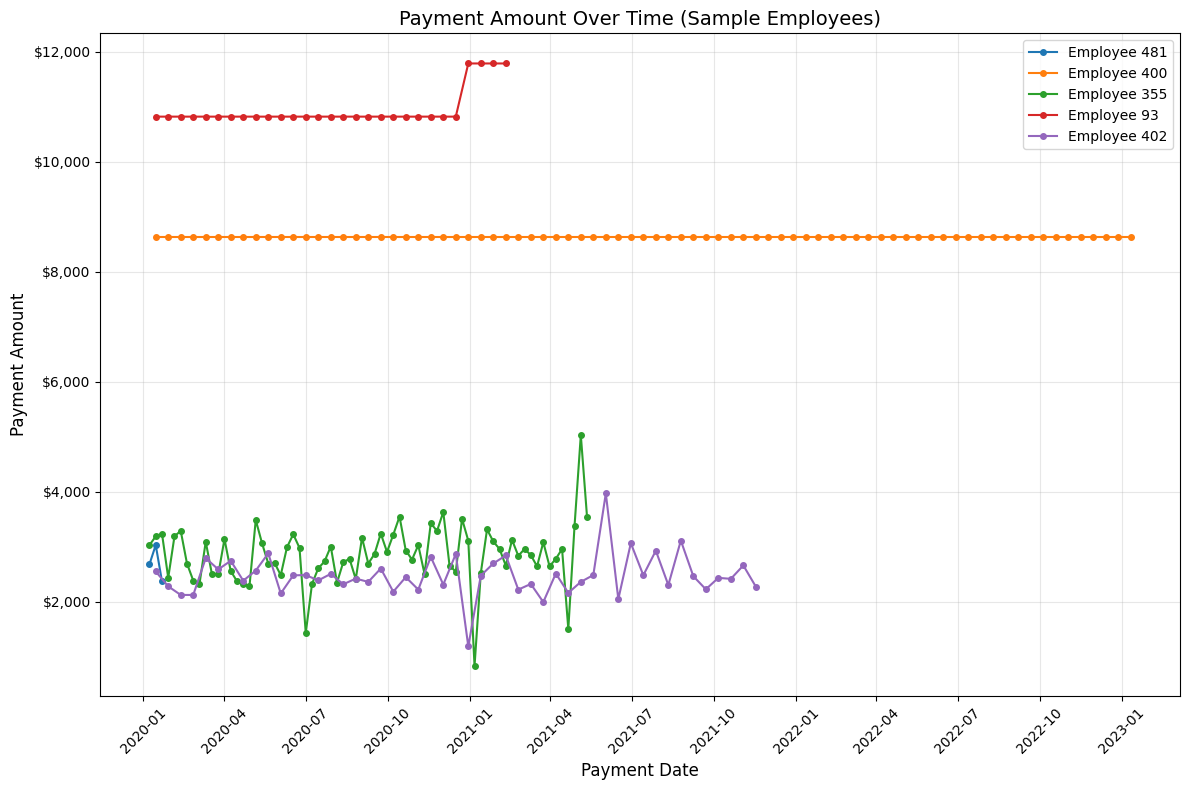

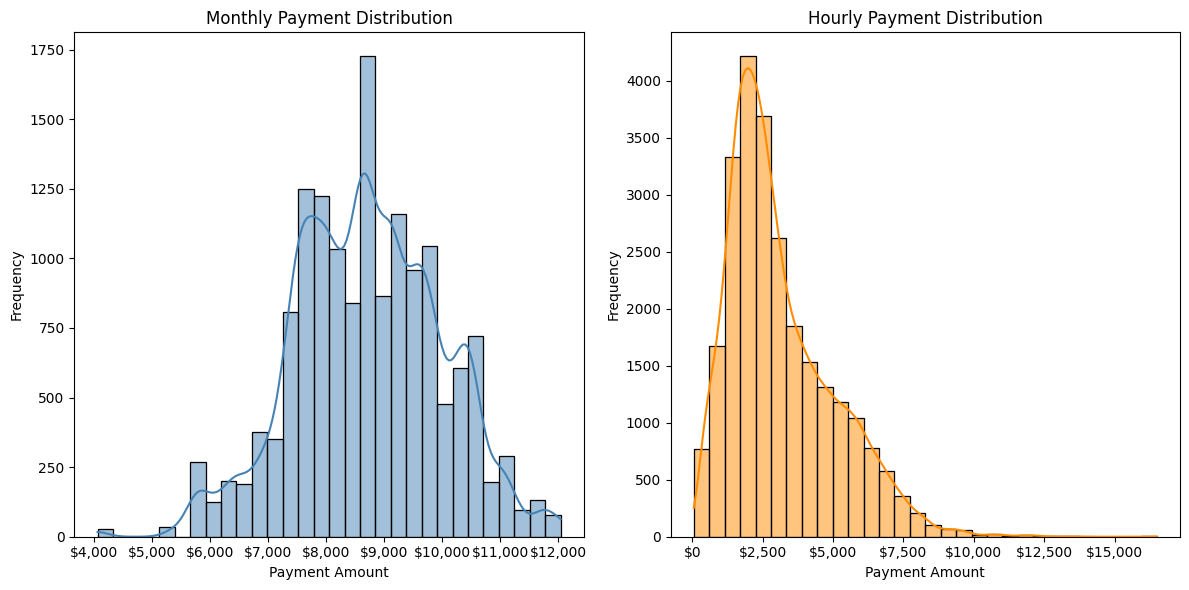

<Figure size 1200x600 with 0 Axes>

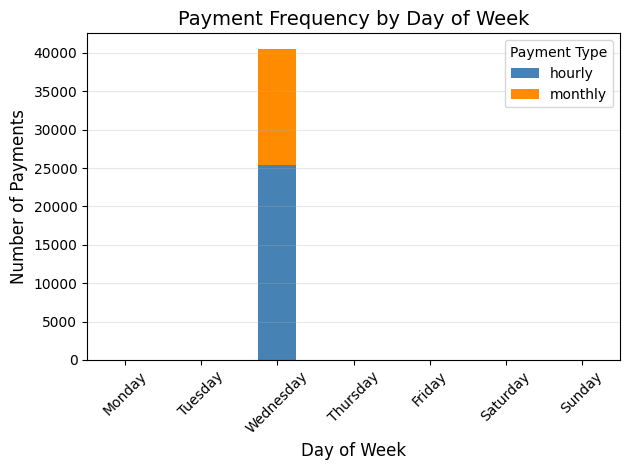

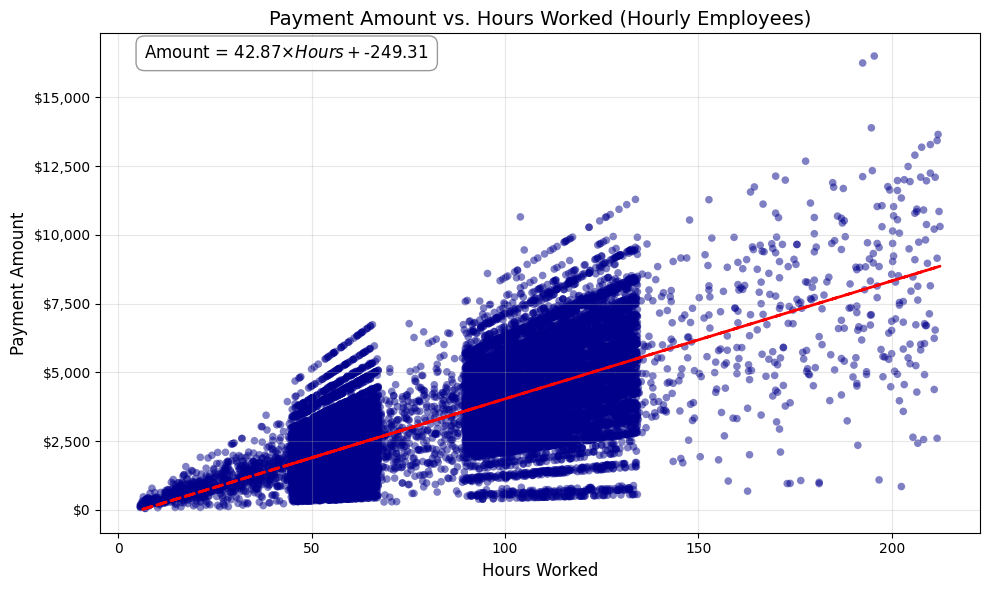

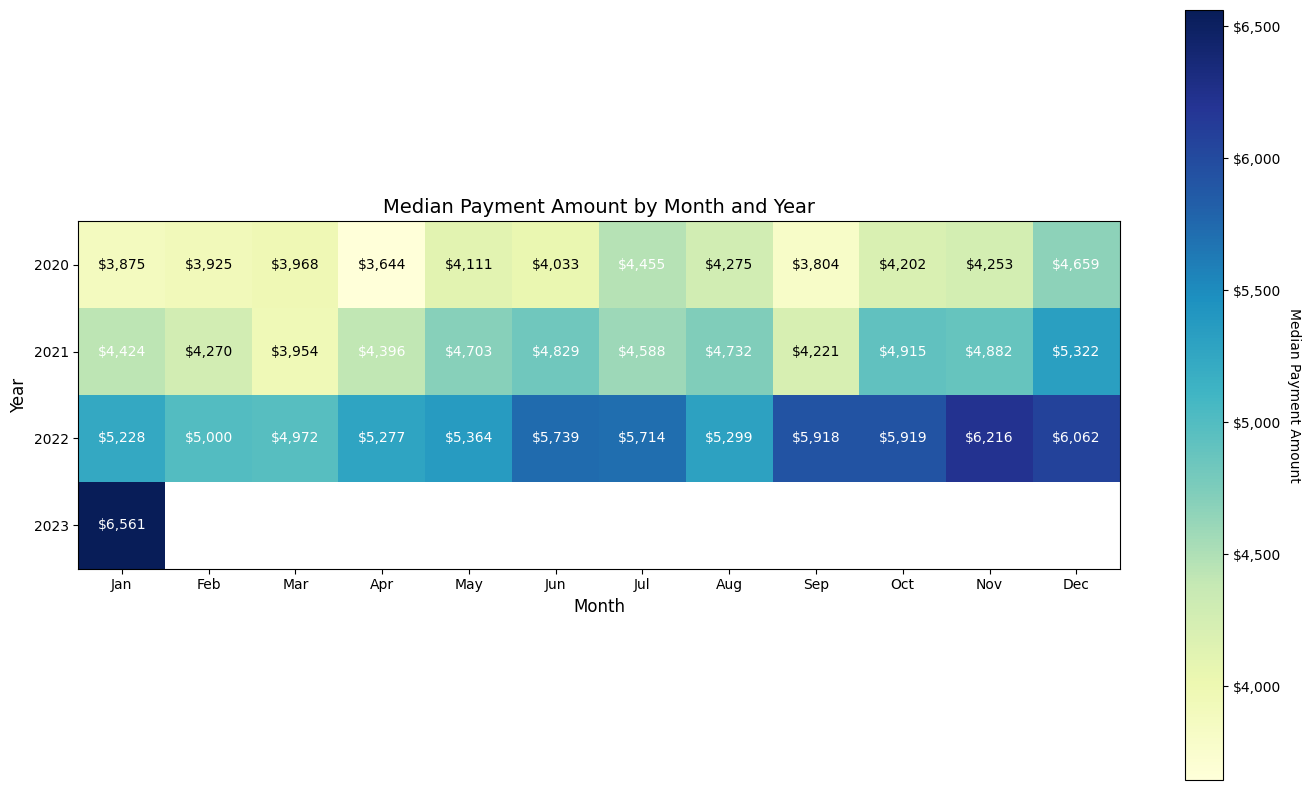

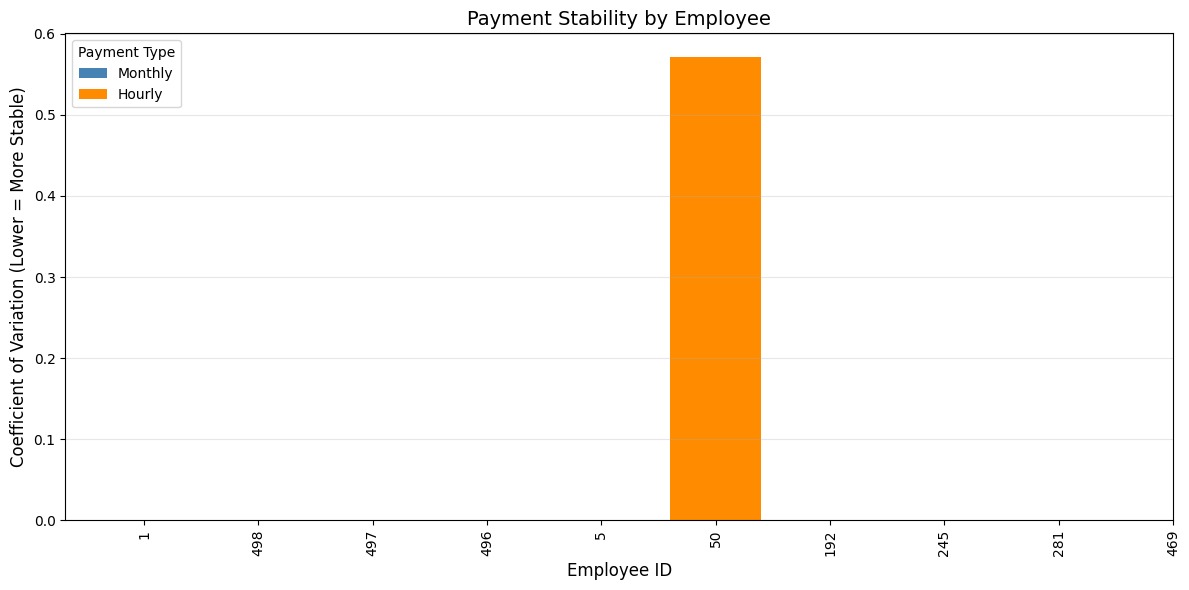

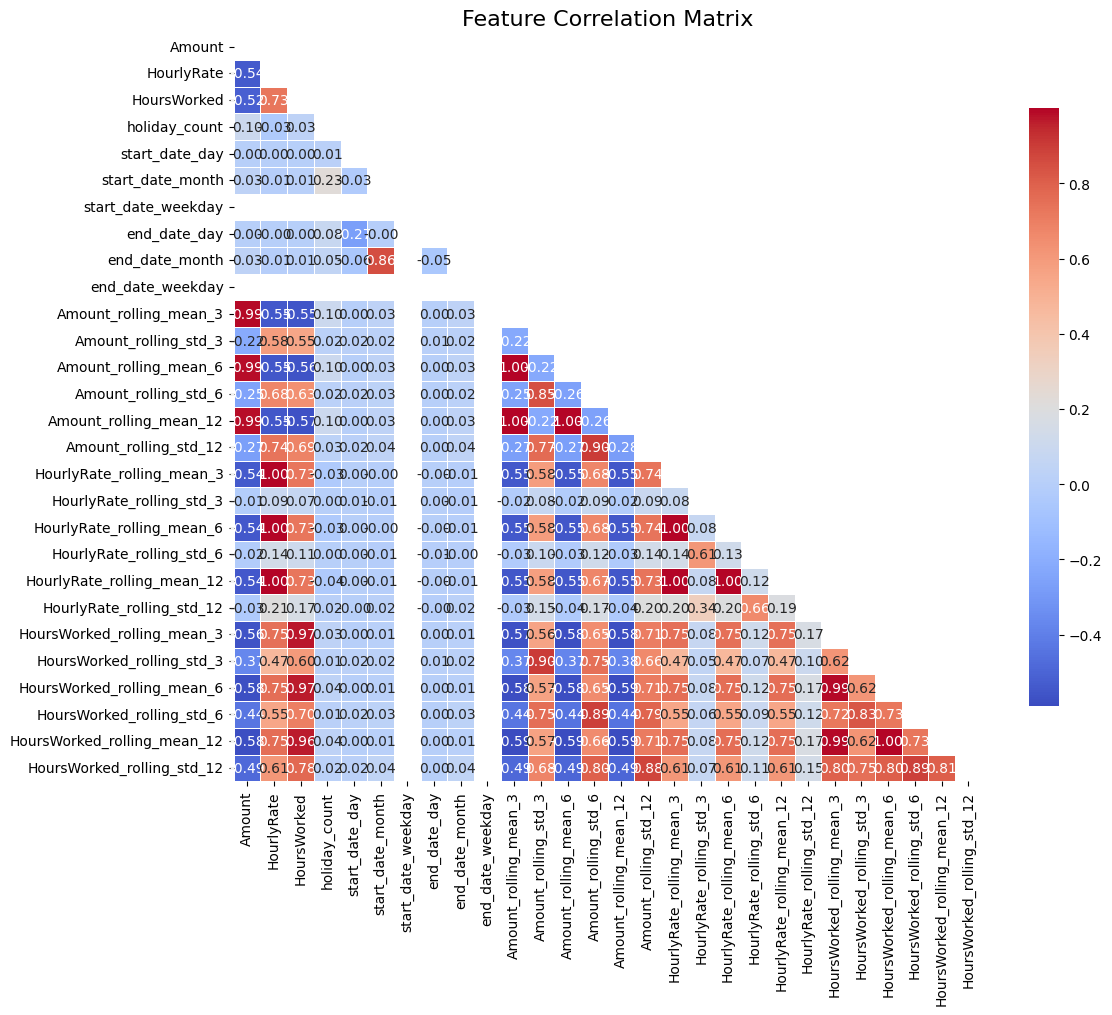

<Figure size 1500x1200 with 0 Axes>

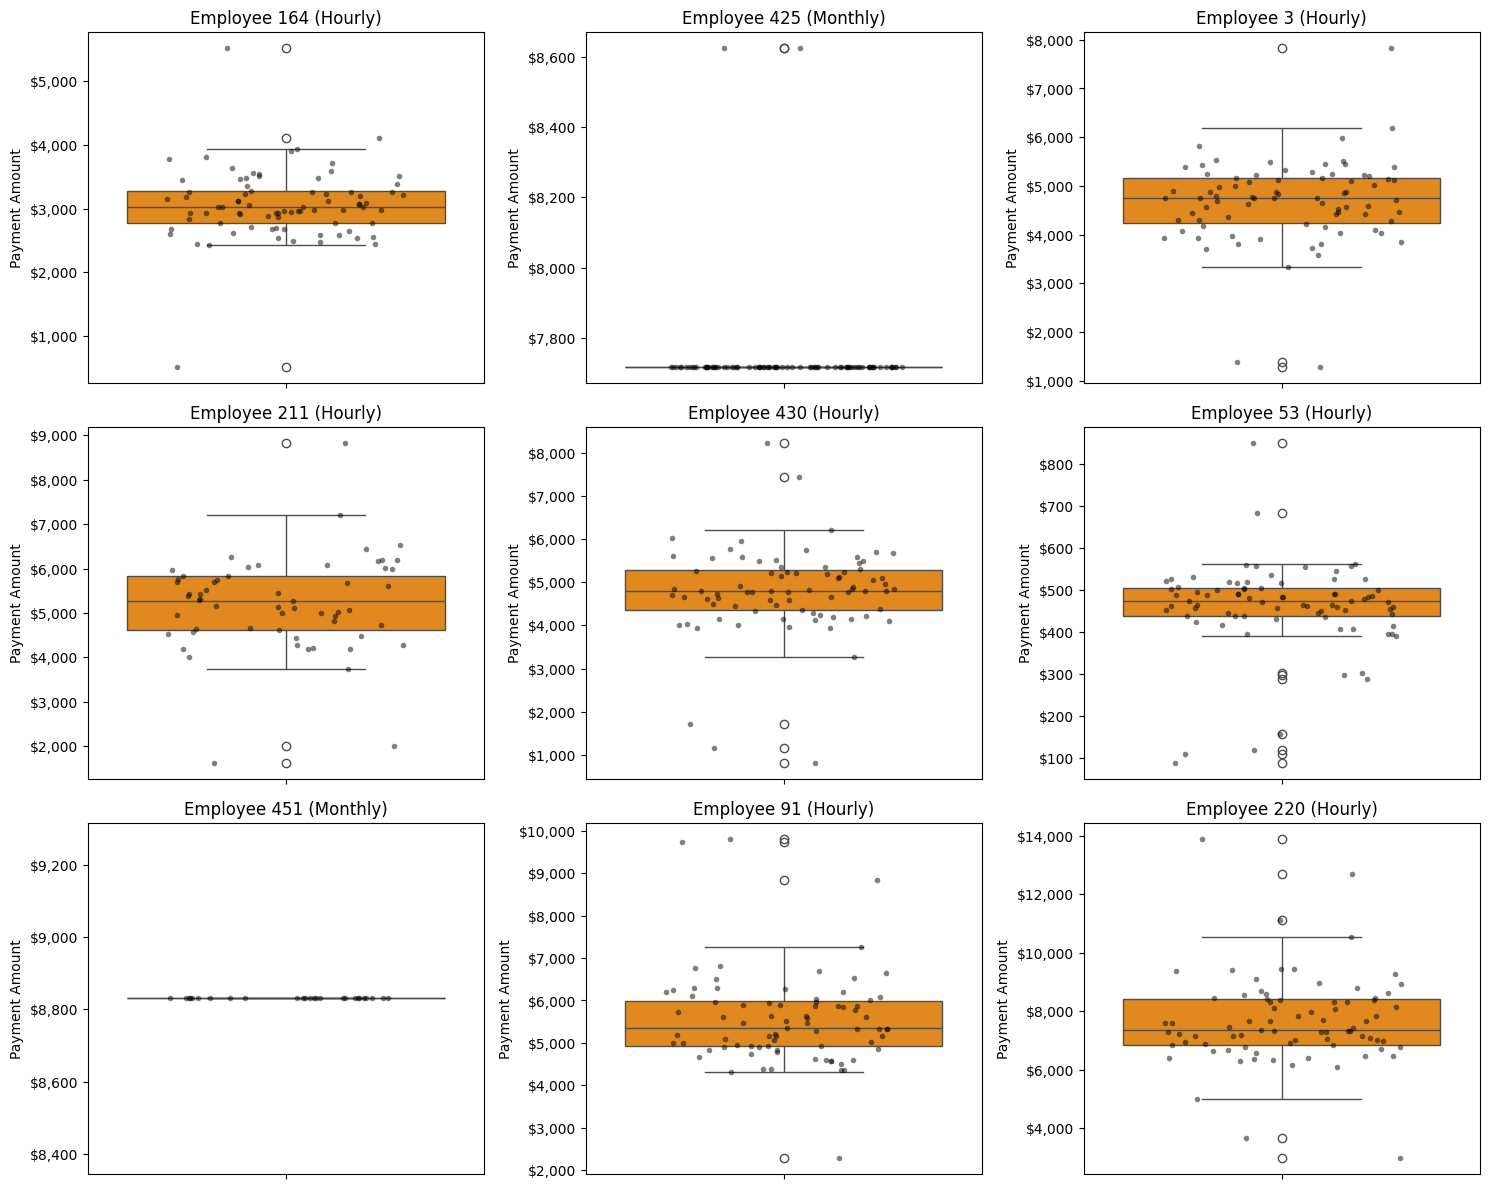

<Figure size 1500x800 with 0 Axes>

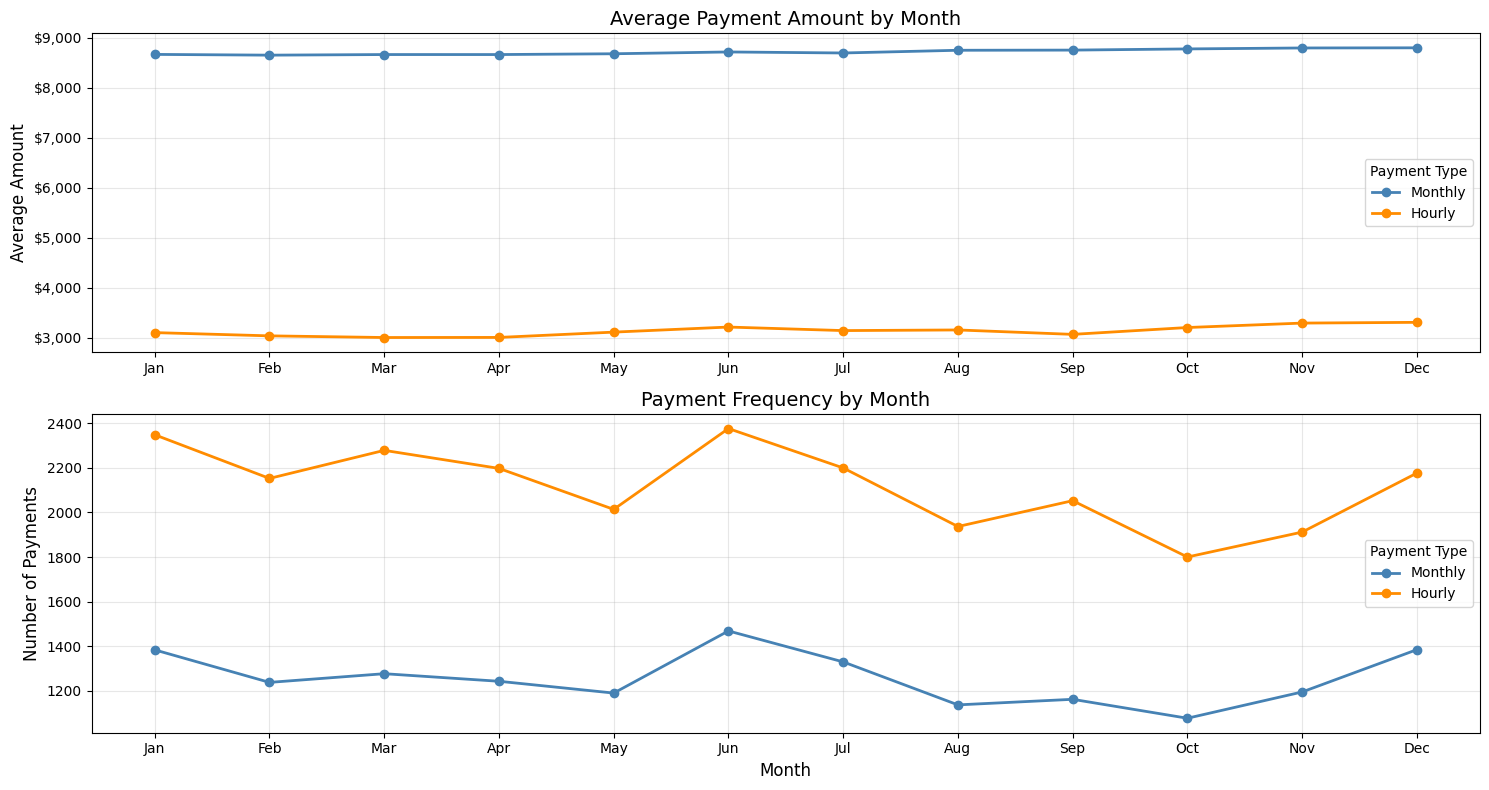

<Figure size 1200x600 with 0 Axes>

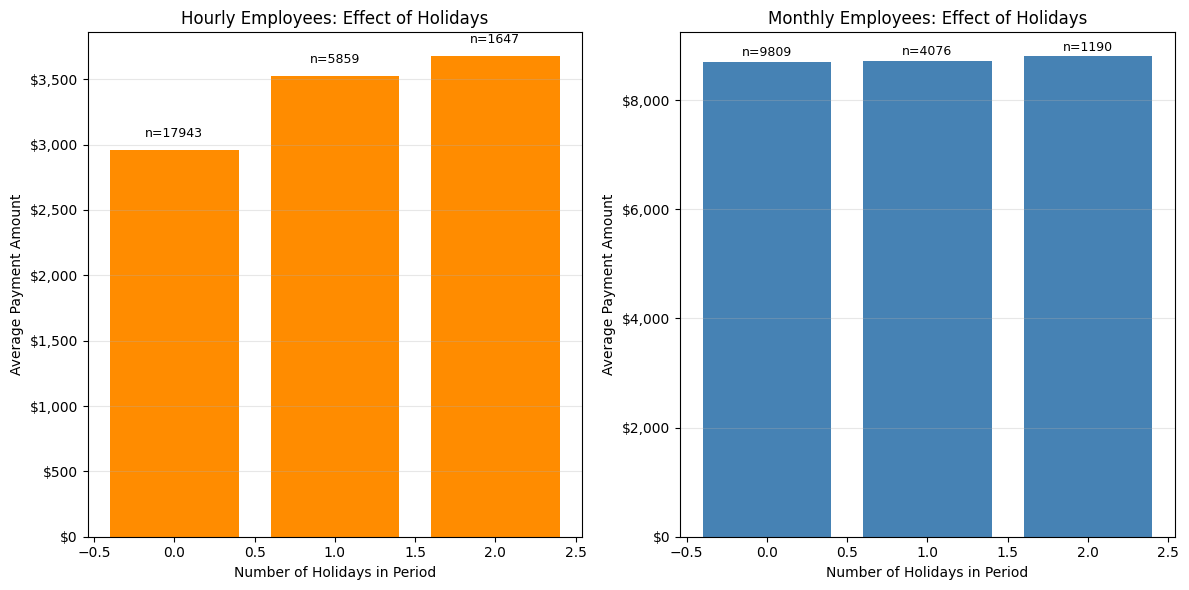

In [7]:
plot_all_eda_visualizations(df)

## Modeling

In [8]:
df[[        'pay_per_hour', 'hours_volatility',
        'hours_lag_1', 'hours_lag_2', 'hours_lag_3',
        'HoursWorked_rolling_mean', 'HoursWorked_rolling_std',
        'HoursWorked_rolling_min', 'HoursWorked_rolling_max']]

,pay_per_hour,hours_volatility,hours_lag_1,hours_lag_2,hours_lag_3,HoursWorked_rolling_mean,HoursWorked_rolling_std,HoursWorked_rolling_min,HoursWorked_rolling_max
23959,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,0.0
37947,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,0.0
37819,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,0.0
24376,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,0.0
27077,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
25332,34.770000,0.133026,117.0,92.75,113.00,112.929104,23.767530,42.5,191.5
5176,34.770045,0.127060,131.0,117.00,92.75,112.893382,23.591332,42.5,191.5
15382,34.770044,0.108873,110.5,131.00,117.00,112.916667,23.418023,42.5,191.5
25037,34.770038,0.124049,114.5,110.50,131.00,113.182143,23.353573,42.5,191.5


In [13]:
def select_model_features(df):
    """Select appropriate features for modeling from the processed dataframe"""
    
    # Core features from the combined feature engineering
    feature_cols = [
        # Basic information
        'is_hourly', 'holiday_count',
        'payment_frequency',
        'days_since_first_payment', 'payment_sequence', 
        
        # Date-related features
        'start_date_day', 'start_date_month',
        'end_date_day', 'end_date_month',
        'quarter', 'year',
        'day_of_year', 'week_of_year',
        
        # Rolling windows
        'Amount_rolling_mean_3', 'Amount_rolling_mean_6', 'Amount_rolling_mean_12',
        'Amount_rolling_std_3', 'Amount_rolling_std_6', 'Amount_rolling_std_12',
        'HourlyRate_rolling_mean_3', 'HourlyRate_rolling_std_3',
        'HoursWorked_rolling_mean_3', 'HoursWorked_rolling_std_3',
        
        # Employee metrics
        'Amount_rolling_mean', 'Amount_rolling_std', 
        'Amount_rolling_min', 'Amount_rolling_max',
        'amount_to_avg_ratio', 'amount_zscore', 'is_amount_outlier',
        'payment_stability',
        
        # Trend indicators
        'amount_pct_change', 'amount_diff',
        'amount_3ma_6ma_diff',
        
        # Lag features
        'amount_lag_1', 'amount_lag_2', 'amount_lag_3',
    ]
    
    # Add hourly employee specific features if they exist
    hourly_specific = [
        'pay_per_hour', 'hours_volatility',
        'hours_lag_1', 'hours_lag_2', 'hours_lag_3',
        'HoursWorked_rolling_mean', 'HoursWorked_rolling_std',
        'HoursWorked_rolling_min', 'HoursWorked_rolling_max'
    ]
    
    # Add available features to the list
    for feature in hourly_specific:
        if feature in df.columns:
            feature_cols.append(feature)
    
    return feature_cols

def time_series_split(df, test_ratio=0.2):
    """Split data temporally for time series validation"""
    # Sort by date
    df = df.sort_values(['EndDate'])
    
    # Find cutoff date
    cutoff_idx = int(len(df) * (1 - test_ratio))
    cutoff_date = df.iloc[cutoff_idx]['EndDate']
    
    # Split data
    train = df[df['EndDate'] < cutoff_date]
    test = df[df['EndDate'] >= cutoff_date]
    
    return train, test

def train_global_model(train_df, test_df, feature_cols):
    """Train a single global model for all employees with minimal parameters"""
    
    # Prepare features and target
    X_train = train_df[feature_cols]
    y_train = train_df['next_amount']
    
    X_test = test_df[feature_cols]
    y_test = test_df['next_amount']
    
    # Remove rows with NaN targets
    train_mask = ~y_train.isna()
    X_train, y_train = X_train[train_mask], y_train[train_mask]
    
    test_mask = ~y_test.isna()
    X_test, y_test = X_test[test_mask], y_test[test_mask]
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    # Initialize model with minimal parameters
    model = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=200,
        learning_rate=0.05,
        random_state=42
    )
    
    # Fit with minimal parameters
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
    
    print("\nModel Evaluation:")
    print(f"MAE: ${mae:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Important Features:")
    print(feature_importance.head(15))
    
    # Return model and evaluation metrics
    return {
        'model': model,
        'predictions': y_pred,
        'actual': y_test,
        'metrics': {
            'MAE': mae,
            'RMSE': rmse,
            'R^2': r2,
            'MAPE': mape
        },
        'feature_importance': feature_importance,
        'test_indices': test_df[test_mask].index
    }

def analyze_model_results(model_results, test_df):
    """Analyze model results in more detail"""
    # Create a DataFrame with actual vs predicted values
    predictions_df = pd.DataFrame({
        'Actual': model_results['actual'],
        'Predicted': model_results['predictions'],
        'Error': model_results['actual'] - model_results['predictions'],
        'AbsError': np.abs(model_results['actual'] - model_results['predictions']),
        'PercentError': np.abs((model_results['actual'] - model_results['predictions']) / model_results['actual']) * 100
    })
    
    # Get the original test data
    test_with_pred = test_df.loc[model_results['test_indices']].copy()
    test_with_pred['Predicted'] = model_results['predictions']
    test_with_pred['Error'] = test_with_pred['next_amount'] - test_with_pred['Predicted']
    test_with_pred['AbsError'] = np.abs(test_with_pred['Error'])
    test_with_pred['PercentError'] = np.abs(test_with_pred['Error'] / test_with_pred['next_amount']) * 100
    
    # Analyze error by payment type
    error_by_type = test_with_pred.groupby('PaymentType').agg({
        'Error': ['mean', 'std'],
        'AbsError': ['mean', 'median'],
        'PercentError': ['mean', 'median'],
        'EmployeeID': 'count'
    })
    
    print("\nError Analysis by Payment Type:")
    print(error_by_type)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 8))
    
    # Add identity line
    max_val = max(predictions_df['Actual'].max(), predictions_df['Predicted'].max())
    min_val = min(predictions_df['Actual'].min(), predictions_df['Predicted'].min())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    # Separate by payment type
    monthly_mask = test_with_pred['PaymentType'] == 'monthly'
    hourly_mask = test_with_pred['PaymentType'] == 'hourly'
    
    # Plot scatter
    plt.scatter(
        test_with_pred.loc[monthly_mask, 'next_amount'], 
        test_with_pred.loc[monthly_mask, 'Predicted'],
        alpha=0.5, c='steelblue', label='Monthly'
    )
    plt.scatter(
        test_with_pred.loc[hourly_mask, 'next_amount'], 
        test_with_pred.loc[hourly_mask, 'Predicted'],
        alpha=0.5, c='darkorange', label='Hourly'
    )
    
    plt.title('Actual vs Predicted Payment Amount', fontsize=14)
    plt.xlabel('Actual Amount', fontsize=12)
    plt.ylabel('Predicted Amount', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Error distribution
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(predictions_df['Error'], bins=50, kde=True)
    plt.title('Distribution of Prediction Errors', fontsize=14)
    plt.xlabel('Error (Actual - Predicted)', fontsize=12)
    plt.axvline(x=0, color='r', linestyle='--')
    
    plt.subplot(1, 2, 2)
    sns.histplot(predictions_df['PercentError'], bins=50, kde=True)
    plt.title('Distribution of Percent Errors', fontsize=14)
    plt.xlabel('Percent Error', fontsize=12)
    plt.axvline(x=0, color='r', linestyle='--')
    
    plt.tight_layout()
    
    # Feature importance plot
    plt.figure(figsize=(10, 8))
    top_features = model_results['feature_importance'].head(15)
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Top 15 Feature Importances', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    
    return test_with_pred

def make_future_predictions(df, model_results, feature_cols, steps=4):
    """Generate future predictions for all employees"""
    model = model_results['model']
    results = []
    
    # For each employee
    for employee_id in df['EmployeeID'].unique():
        # Get employee data
        employee_df = df[df['EmployeeID'] == employee_id].copy().sort_values('EndDate')
        
        # Need at least some history
        if len(employee_df) < 5:
            continue
            
        # Get payment type
        payment_type = employee_df['PaymentType'].iloc[0]
        
        # Get last date
        last_date = employee_df['EndDate'].iloc[-1]
        
        # Figure out payment frequency
        if 'days_between' in employee_df.columns and len(employee_df) > 1:
            payment_freq = employee_df['days_between'].median()
            if np.isnan(payment_freq) or payment_freq <= 0:
                payment_freq = 14  # Default to bi-weekly
        else:
            payment_freq = 14  # Default to bi-weekly
        
        # Make future predictions
        current_data = employee_df.iloc[-1:].copy()
        
        for step in range(steps):
            # Update dates for next prediction
            next_date = current_data['EndDate'].iloc[-1] + pd.Timedelta(days=int(payment_freq))
            current_data['StartDate'] = current_data['EndDate']
            current_data['EndDate'] = next_date
            
            # Update date-based features
            current_data['start_date_day'] = current_data['StartDate'].dt.day
            current_data['start_date_month'] = current_data['StartDate'].dt.month
            current_data['start_date_weekday'] = current_data['StartDate'].dt.weekday
            current_data['end_date_day'] = current_data['EndDate'].dt.day
            current_data['end_date_month'] = current_data['EndDate'].dt.month
            current_data['end_date_weekday'] = current_data['EndDate'].dt.weekday
            current_data['quarter'] = current_data['StartDate'].dt.quarter
            current_data['year'] = current_data['StartDate'].dt.year
            current_data['day_of_year'] = current_data['StartDate'].dt.dayofyear
            current_data['week_of_year'] = current_data['StartDate'].dt.isocalendar().week
            
            # Update holiday count if the function is available
            if 'count_holidays' in globals():
                current_data['holiday_count'] = current_data.apply(
                    lambda row: count_holidays(row['StartDate'], row['EndDate']), axis=1
                )
            
            # Make prediction
            X_pred = current_data[feature_cols]
            prediction = model.predict(X_pred)[0]
            
            # Store result
            results.append({
                'EmployeeID': employee_id,
                'PaymentType': payment_type,
                'PredictionDate': next_date,
                'PredictedAmount': prediction,
                'StepAhead': step + 1
            })
            
            # Update for next prediction
            current_data['Amount'] = prediction
            
            # Update lag features if they exist
            if 'amount_lag_1' in feature_cols:
                current_data['amount_lag_1'] = prediction
            if 'amount_lag_2' in feature_cols and 'amount_lag_1' in employee_df.columns:
                current_data['amount_lag_2'] = employee_df['amount_lag_1'].iloc[-1]
            if 'amount_lag_3' in feature_cols and 'amount_lag_2' in employee_df.columns:
                current_data['amount_lag_3'] = employee_df['amount_lag_2'].iloc[-1]
    
    return pd.DataFrame(results)

def run_simplified_model_pipeline(df):
    """Run complete pipeline with a single global model"""
    print("Starting simplified paycheck prediction pipeline...")
    
    # Step 1: Feature engineering (assuming prepare_full_feature_set function exists)
    print("\nPreparing features...")
    processed_df = prepare_full_feature_set(df)
    feature_cols = select_model_features(processed_df)
    
    print(f"Data shape after processing: {processed_df.shape}")
    print(f"Selected {len(feature_cols)} features for modeling")
    
    # Step 2: Train-test split
    print("\nSplitting data for training and testing...")
    train_df, test_df = time_series_split(processed_df, test_ratio=0.2)
    print(f"Training set size: {train_df.shape[0]} records")
    print(f"Testing set size: {test_df.shape[0]} records")
    
    # Step 3: Train global model
    print("\nTraining global model...")
    model_results = train_global_model(train_df, test_df, feature_cols)
    
    # Step 4: Analyze results
    print("\nAnalyzing model results...")
    analysis_df = analyze_model_results(model_results, test_df)
    
    # Step 5: Generate future predictions
    print("\nGenerating future predictions...")
    future_predictions = make_future_predictions(processed_df, model_results, feature_cols)
    
    print("\nModel pipeline complete!")
    
    return {
        'model': model_results['model'],
        'metrics': model_results['metrics'],
        'feature_importance': model_results['feature_importance'],
        'analysis_df': analysis_df,
        'future_predictions': future_predictions
    }

def evaluate_model_by_employee(test_with_pred):
    """Evaluate model performance by employee"""
    # Group by employee and calculate metrics
    employee_metrics = test_with_pred.groupby('EmployeeID').agg({
        'next_amount': ['mean', 'std', 'count'],
        'Predicted': 'mean',
        'AbsError': 'mean',
        'PercentError': 'mean',
        'PaymentType': lambda x: x.iloc[0]
    })
    
    # Flatten multi-index columns
    employee_metrics.columns = ['_'.join(col).strip() for col in employee_metrics.columns.values]
    
    # Sort by error
    employee_metrics = employee_metrics.sort_values('AbsError_mean', ascending=False)
    
    # Calculate overall stats by payment type
    payment_type_metrics = test_with_pred.groupby('PaymentType').agg({
        'AbsError': ['mean', 'median', 'std'],
        'PercentError': ['mean', 'median', 'std'],
        'EmployeeID': 'nunique'
    })
    
    # Plot error distribution by payment type
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x='PaymentType', y='AbsError', data=test_with_pred)
    plt.title('Absolute Error by Payment Type', fontsize=14)
    plt.ylabel('Absolute Error', fontsize=12)
    plt.xlabel('Payment Type', fontsize=12)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='PaymentType', y='PercentError', data=test_with_pred)
    plt.title('Percent Error by Payment Type', fontsize=14)
    plt.ylabel('Percent Error (%)', fontsize=12)
    plt.xlabel('Payment Type', fontsize=12)
    
    plt.tight_layout()
    
    # Return metrics
    return employee_metrics, payment_type_metrics

Starting simplified paycheck prediction pipeline...

Preparing features...
Data shape after processing: (40524, 70)
Selected 46 features for modeling

Splitting data for training and testing...
Training set size: 32339 records
Testing set size: 8185 records

Training global model...
Training data shape: (32178, 46)
Testing data shape: (7846, 46)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8430
[LightGBM] [Info] Number of data points in the train set: 32178, number of used features: 46
[LightGBM] [Info] Start training from score 5093.997411

Model Evaluation:
MAE: $292.77
RMSE: $632.79
R²: 0.9604
MAPE: 11.10%

Top 15 Important Features:
                       Feature  Importance
42    HoursWorked_rolling_mean         484
23         Amount_rolling_mean         432
13       Amount_rolling_mean_3         252
15      Amount_rolling_mean_12       

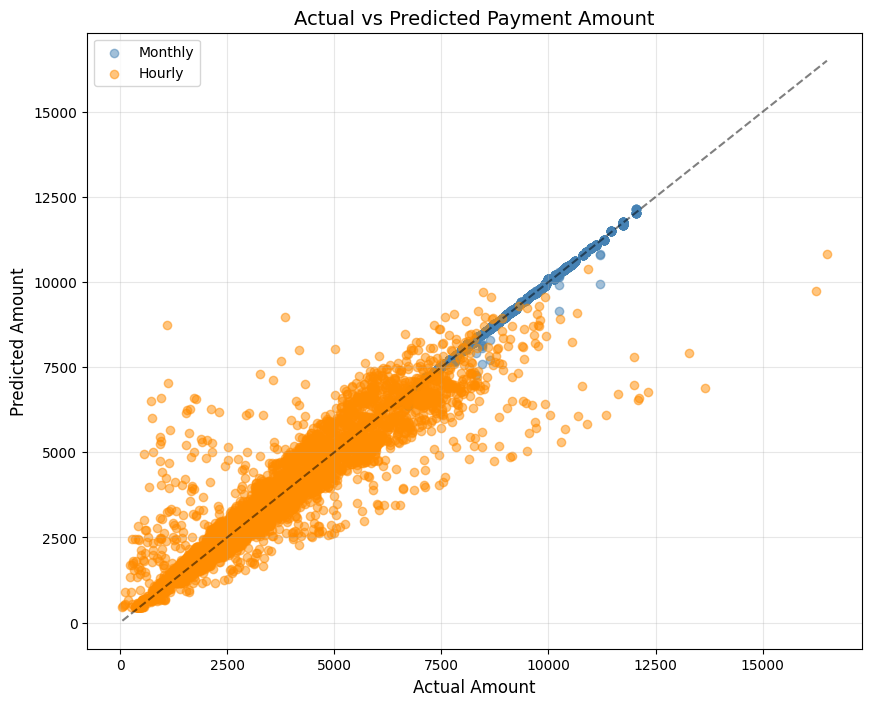

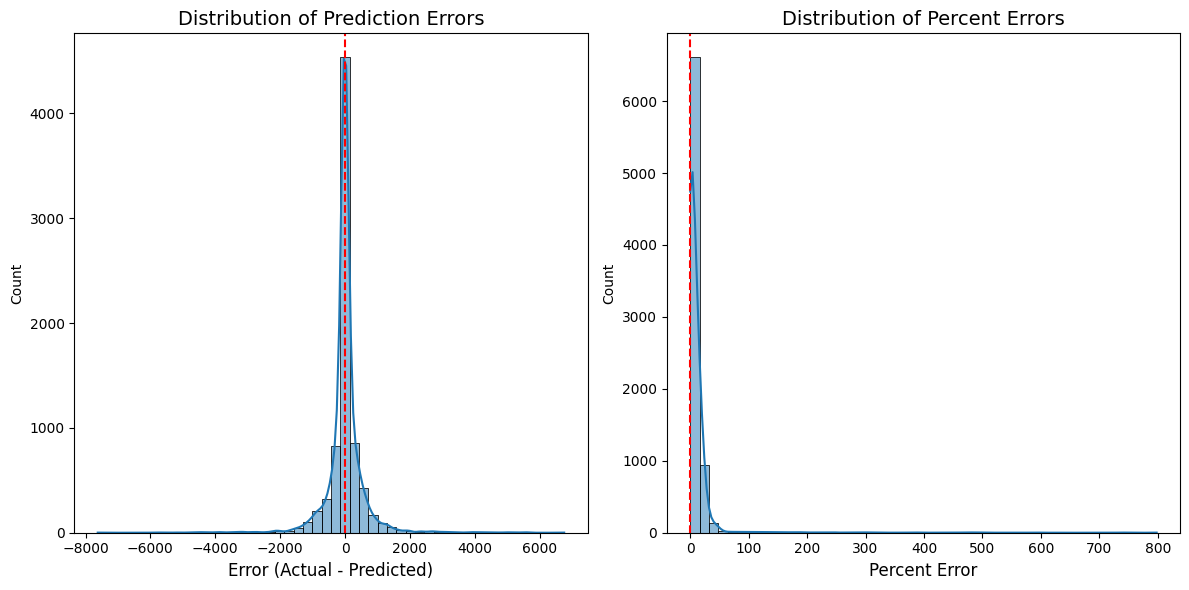

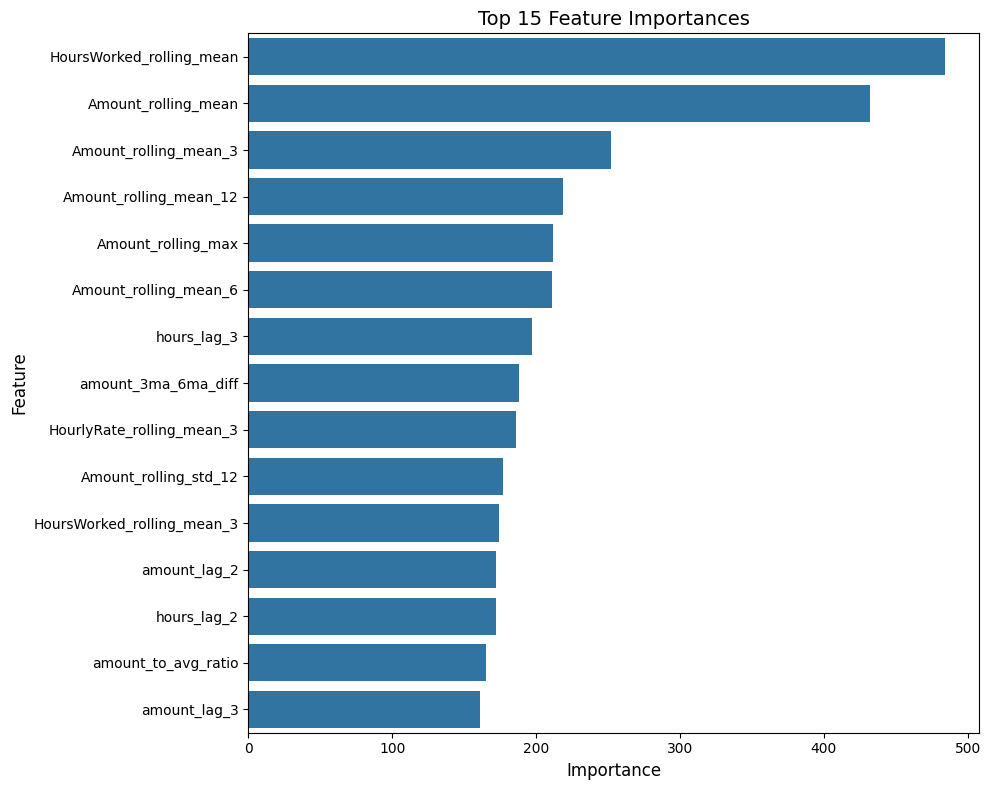

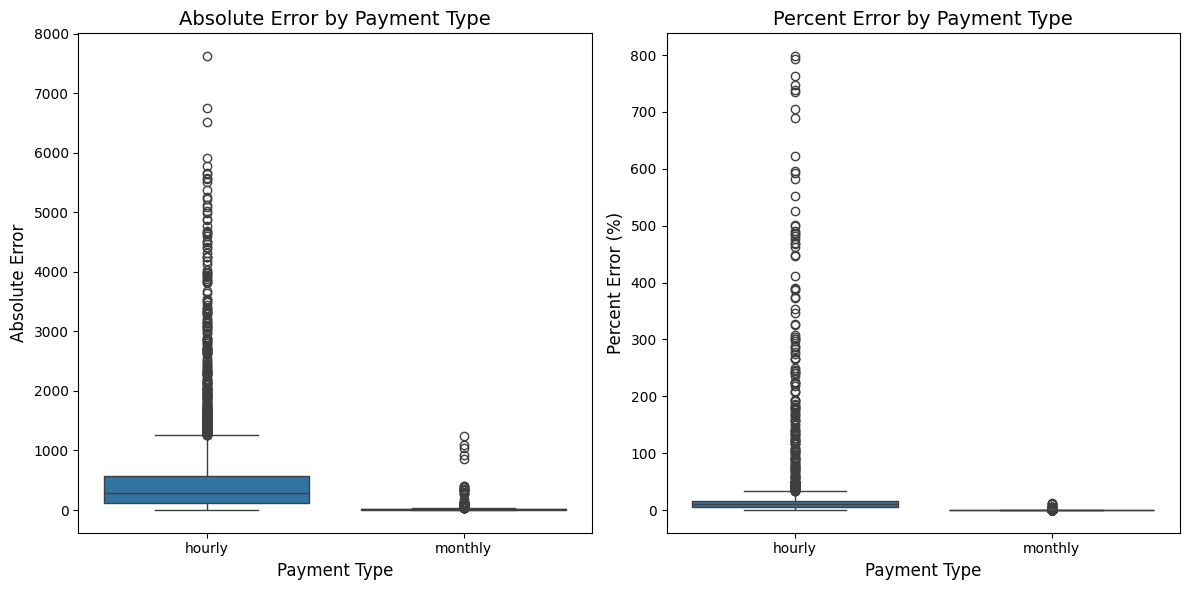

In [14]:
results = run_simplified_model_pipeline(df)

# Access the model and predictions
model = results['model']
metrics = results['metrics']
future_predictions = results['future_predictions']

# Generate additional employee-level analysis
employee_metrics, payment_type_metrics = evaluate_model_by_employee(results['analysis_df'])

# View most important features
print(results['feature_importance'].head(10))

# Look at predictions for specific employees
employee_id = 250
employee_predictions = future_predictions[future_predictions['EmployeeID'] == employee_id]
print(employee_predictions)

In [21]:
employee_id = 3
employee_predictions = future_predictions[future_predictions['EmployeeID'] == employee_id]
print(employee_predictions)

    EmployeeID PaymentType PredictionDate  PredictedAmount  StepAhead
8            3      hourly     2023-01-25      5036.557360          1
9            3      hourly     2023-02-08      5113.986324          2
10           3      hourly     2023-02-22      5162.284946          3
11           3      hourly     2023-03-08      5178.036166          4
